In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import pop_tools

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Notebook parameters

In [2]:
mask_name = 'krill-ToE'
grid_name = 'POP_gx1v6'

## Check for chached zarr_name

In [3]:
# TODO: can the jupyter notebook return here if `zarr_name` exists?
zarr_name = f'./data/region-mask-{grid_name}-{mask_name}.zarr'

## Construct a region mask

Get the model grid.

In [4]:
grid = pop_tools.get_grid(grid_name)
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
Attributes:
    lateral_dims:         [384, 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

In [5]:
defined_mask_logic = {
    'krill-ToE': [
        ('Southern Ocean', (grid.TLAT <= -45)), 
        ('WAP & Atlantic', (grid.TLAT <= -45) & ((grid.TLONG > 260) | (grid.TLONG < 25))),
        ('Indo-Pacific', (grid.TLAT <= -45) & ~((grid.TLONG > 260) | (grid.TLONG < 25))),    
    ]
}

if mask_name in defined_mask_logic:
    mask_logic = defined_mask_logic[mask_name]

else:
    raise ValueError(f'unknown mask: {mask_name}')

mask_logic    

[('Southern Ocean',
  <xarray.DataArray 'TLAT' (nlat: 384, nlon: 320)>
  array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])
  Dimensions without coordinates: nlat, nlon),
 ('WAP & Atlantic',
  <xarray.DataArray (nlat: 384, nlon: 320)>
  array([[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])
  Dimensions without coordinates: nlat, nlon),
 ('Indo-Pacific',
  <xarray.DataArray (nlat: 

In [6]:
# define a list of tuples describing our regions: 
#  (region_name, logical_array)

# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)


# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

masked_area    

<xarray.DataArray 'masked_area' (region: 3, nlat: 384, nlon: 320)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * region   (region) <U14 'Southern Ocean' 'WAP & Atlantic' 'Indo-Pacific'
Dimensions without coordinates: nlat, nlon

Make a quick-look plot of the regions.

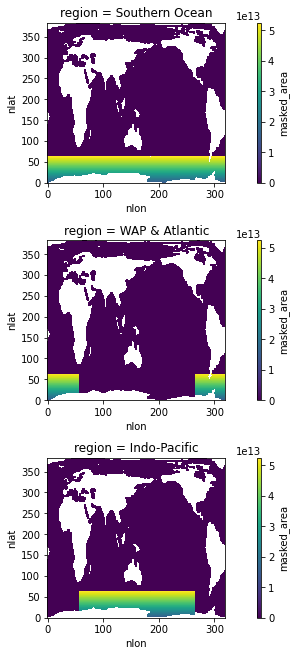

In [7]:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()    

Check that the sum across the region dimension is as expected. Land should have the value `nregion` and elsewhere the coverage should reflect the number of regions the cover each cell, e.g., if there is no overlap, the plot should show "1".

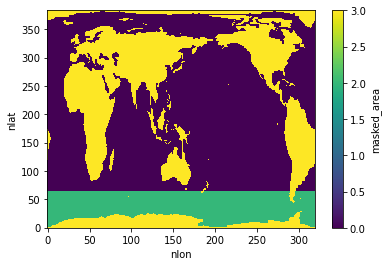

In [8]:
masked_area.where(masked_area==0).fillna(1.).sum('region').plot();

In [9]:
util.write_ds_out(masked_area.to_dataset(), zarr_name)

------------------------------
Writing /glade/u/home/mclong/codes/funnel/notebooks/data/region-mask-POP_gx1v6-krill-ToE.zarr
<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, region: 3)
Coordinates:
  * region       (region) <U14 'Southern Ocean' 'WAP & Atlantic' 'Indo-Pacific'
Dimensions without coordinates: nlat, nlon
Data variables:
    masked_area  (region, nlat, nlon) float64 nan nan nan nan ... nan nan nan

